In [52]:
import IPython
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
from scipy.ndimage import convolve
from scipy.fftpack import dct, dctn, idctn
from scipy.linalg import circulant
import pywt
from sklearn import linear_model
from IPython.display import clear_output, display
import seaborn as sns
import matplotlib as mpl
mpl.rc('image', cmap='Blues')

import cvxpy as cp
import pandas as pd

Let's load the [Shepp-Logan phantom](https://en.wikipedia.org/wiki/Shepp–Logan_phantom) and resize it to be $ 128 \times 128 $.

In [4]:
width = 128
img = cv2.imread('./SheppLogan_Phantom.png',0, )
img = cv2.resize(img, dsize=(width,width))
N = np.prod(img.shape) # The dimension after flattening

Here's a function that tells us the sparsity of an image, i.e. the proportion of non-zero pixels it has:

In [5]:
def sparsity(img):
    return (np.sum(np.abs(img) > 1e-9) / np.prod(img.shape))

And the next function tells us the progress in a for loop while we're waiting:

In [6]:
def print_progress(n, i):
    
    if i % np.max([(n // 100), 1]) == 0:
        clear_output(wait=True)
        print((i + 1) * 100 // n, "% done")

Since the image in the original basis is not sparse, we look at its Laplacian which is sparse. We also normalize the coefficients to be 0 or 1:

Sparsity:  0.06317138671875


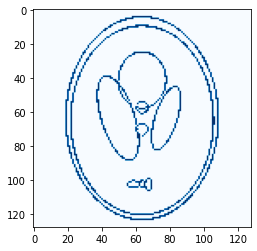

In [8]:
thresh = 0  # A threshold to zero coefficients
lap = cv2.Laplacian(img,cv2.CV_64F,ksize=1)
lap_th = np.copy(lap)
lap_th[lap_th < thresh] = 0
lap_th[lap_th != 0] = 1
plt.imshow(lap_th)
print("Sparsity: ", sparsity(lap_th))

In [38]:
N = np.prod(img.shape)  # Size of experimental domain
p = N  # Covariate Dimension
n = p // 2  #Sample size; we undersample by 50%
print('shape: ', img.shape)
print('dim: ', p)
print('sparsity of the original image: ', sparsity(img))
print('sparsity of the Laplacian: ', sparsity(lap_th))

shape:  (128, 128)
dim:  16384
sparsity of the original image:  0.42742919921875
sparsity of the Laplacian:  0.06317138671875


We will be (under-)sampling the [Discrete Cosine Transform](https://en.wikipedia.org/wiki/Discrete_cosine_transform) of the image, so let's look at this transform and its inverse:

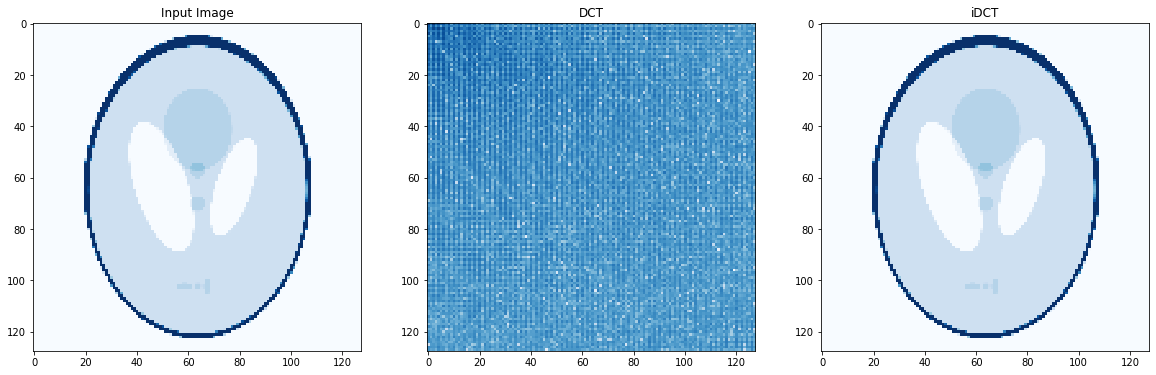

In [21]:
C = dctn(img, norm='ortho')
# Cshift = np.log(np.abs(np.fft.fftshift(C)))
invC = idctn(C, norm='ortho')
plt.figure(figsize=(20,20))
plt.subplot(131),plt.imshow(img)
plt.title('Input Image')
plt.subplot(132),plt.imshow(np.log(np.abs(C)))
plt.title('DCT')
plt.subplot(133), plt.imshow(invC)
plt.title('iDCT')
plt.show()

The matrix of the 2d DCT transform in the vectorized basis can be obtained using Kronecker products:

In [13]:
d = dct(np.eye(img.shape[0]), norm='ortho')
D = np.kron(d,d).T

We take the experimental domain to be this matrix $D$ scaled by $\sqrt{N}$:

In [16]:
X = np.sqrt(N) * D.copy()

Let's say we are interested in the average intensity of the image within the gray rectangular area:

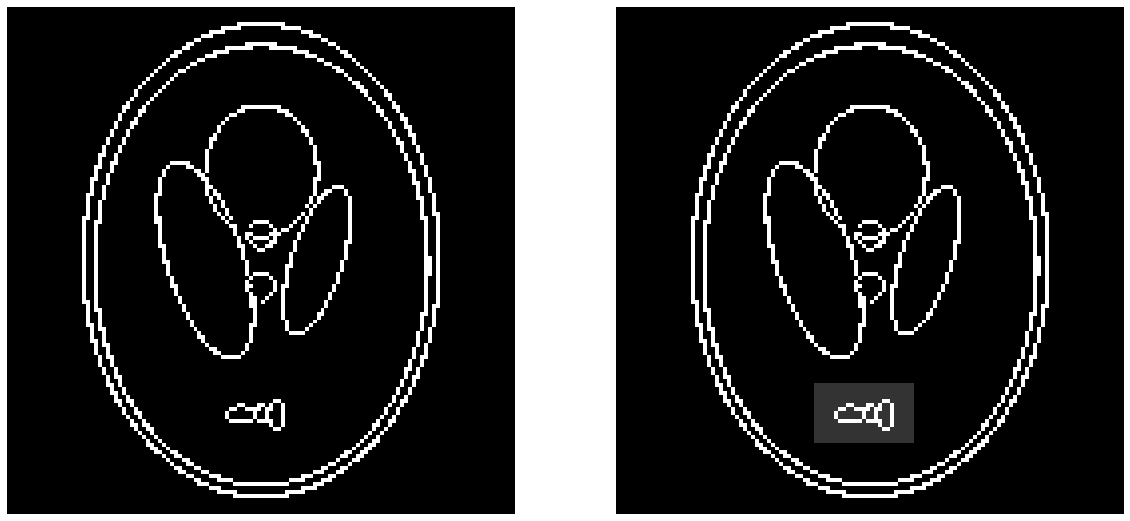

In [17]:
c_arr = np.zeros(img.shape)
c_arr[95:110, 50:75] = 1
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(lap_th, vmin=0, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(np.minimum(lap_th + 0.2*c_arr, 1), vmin=0, cmap='gray')
plt.axis('off')
plt.savefig('shepp_lap_filter.png', format="png", cmap='gray', vmin=0, dpi=700, bbox_inches='tight')

The true coefficient $\beta$ is taken to be the vectorized Laplacian. $c$ is the indicator function of the rectangular area above.

In [18]:
beta = lap_th.reshape(N)
c = c_arr.reshape(N)
c = c / np.sum(np.abs(c))
gamma = beta.T @ c

Given this value of $c$ and $X$, we need to solve the following linear program:
$$
\begin{align*}
\text{P1: minimize}_{w \geq 0} &\quad c^T \Sigma^{-1} c \\
\text{s.t. }\quad &\Sigma = \sum_{i=1}^N w_i x_i x_i^T\\
&\sum_{i=1}^N w_i = 1
\end{align*}
$$

Fortunately, this can be written as a linear program:
$$
\begin{align*}
\text{P2: minimize}_{a,b} &\quad \sum_i a_i \\
\text{s.t. }\quad &c  = \sum_{i=1}^N b_i x_i^T\\
&a \geq b\\
&a \geq -b
\end{align*}
$$

Given an optimal solution $(a^\star, b^\star)$ of $P2$, a solution of $P1$ is found by $w^\star = |a| / \| a\|_1$. The following code solve $P2$ using the cvxpy package. Since it takes a long time to solve this program, I have saved the solution to a file called `w_opt.csv` which I just read it next.

In [ ]:
w = cp.Variable((N), nonneg = True)
z = cp.Variable((N))
constraints = [X.T @ z == c, z - w <= 0, -z - w <= 0]
obj = cp.Minimize(cp.sum(w))
prob = cp.Problem(obj, constraints)

In [ ]:
prob.solve(verbose = True, abstol = 1e-5)

In [ ]:
w_opt = w.value / np.sum(w.value)

In [70]:
def c_optimize(X,c):
    N = X.shape[0]
    w = cp.Variable((N), nonneg = True)
    z = cp.Variable((N))
    constraints = [X.T @ z == c, z - w <= 0, -z - w <= 0]
    obj = cp.Minimize(cp.sum(w))
    prob = cp.Problem(obj, constraints)
    prob.solve(verbose = True, abstol = 1e-5)
    return(w.value / np.sum(w.value))
    

In [ ]:
#np.savetxt("w_opt.csv", w_opt, delimiter=",")

## Read optimal weights

In [22]:
w_opt = np.loadtxt("w_opt.csv", delimiter=",")

Let's take a look at the distirbution of the weights, or rather, their $\log$:

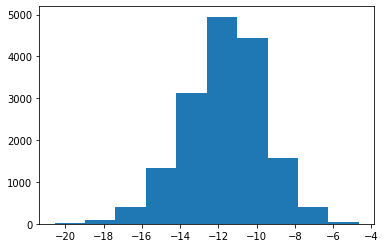

In [23]:
plt.hist(np.log(w_opt[w_opt > 0]))
plt.show()

As seen below, the optimal design improves the asymptotic standard error of the de-biased lasso estimator by a factor of $\approx 5$:

In [25]:
sigma_opt = np.sqrt(c.T @ np.linalg.solve( X.T @ np.diag(w_opt) @ X, c))

In [26]:
sigma_unif = np.sqrt(c.T @ np.linalg.solve( X.T @ X / N, c))

In [27]:
(sigma_unif / sigma_opt)

4.974722710380465

In [28]:
from sklearn.linear_model import Lasso, LassoCV
from random import sample

The next function computes the de-biased lasso estimator:

In [37]:
def deb_lasso(x, y, c, u, lasso_tuning, beta_init):
    n = len(y)
    clf = Lasso(alpha=lasso_tuning, fit_intercept=False,
               warm_start=True, max_iter = 999999, copy_X = True,
                normalize = False)
    norms = np.sqrt(np.mean(x**2, axis = 0))
    clf.coef_ = beta_init  #Initialize at truth for faster computation
    clf.fit(x / norms, y)
    beta_hat = clf.coef_ / norms
    gamma_hat = c.T @ beta_hat + u.T @ x.T @ (y - x @ beta_hat) / n
    return [gamma_hat, beta_hat]

In [30]:
signal = X @ beta

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 5 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.0min finished


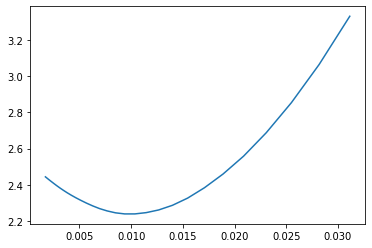

In [40]:
n = N // 2
lambda_theory = np.sqrt(np.log(N)/ n)
indices = np.random.choice(range(N), size=n)

y = signal[indices] + np.random.normal(size=n)

lasso_fit = LassoCV(cv = 10, fit_intercept=False, 
                    alphas=(np.exp(np.arange(-3, 0, 1e-1)))*lambda_theory,
                    n_jobs = -1, max_iter = 999999, verbose=True).fit(X[indices,:],y)

plt.plot(lasso_fit.alphas_, np.mean(lasso_fit.mse_path_, axis = 1))
plt.show()

In [43]:
beta_hat = lasso_fit.coef_
print(gamma)
print("Error: ", np.sum(np.abs(beta - beta_hat)))
print(np.sum(beta))
print(lambda_theory, lasso_fit.alpha_)
cv_lambda = lasso_fit.alpha_

0.10666666666666666
Error:  42.898707944147674
1035.0
0.03441769459380233 0.009379916019746007


# Uniform Sampling

In [31]:
n = N // 2
lambda_theory = np.sqrt(np.log(N)/ n)
u_unif = c
gamma = c.T @ beta
signal = X @ beta

In [57]:
gamma

0.10666666666666666

In [37]:
n = N // 2
n_reps = 5
gammas_unif = np.zeros(n_reps)
signal = X @ beta
beta_hat = np.zeros(N)

for i in range(n_reps):
    indices = np.random.choice(range(N), size=n)
    y = signal[indices] + np.random.normal(size=n)    
    gammas_unif[i], beta_hat = deb_lasso(X[indices,:], y, c, u_unif, lambda_theory, beta_hat.copy())
    
    print_progress(n_reps, i)
#     print(gammas_unif[i] - gamma)

100 % done
-0.010557183864339681


In [67]:
np.savetxt(fname = 'unif_dist.csv', X = gammas_unif, delimiter = ',')

In [33]:
gammas_unif = np.loadtxt("unif_dist.csv", delimiter=",")

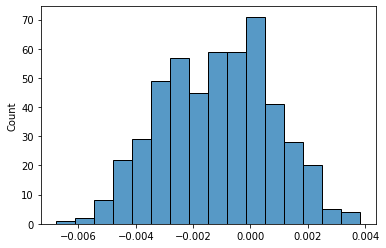

bias:  -0.00115171559733028
std:  0.0019342389201397066


NameError: name 'n' is not defined

In [35]:
sns.histplot(gammas_unif - gamma)
plt.show()
print("bias: ", np.mean(gammas_unif) - gamma)
print("std: ", np.std(gammas_unif))
print((np.linalg.norm(c) / np.sqrt(n)))

In [ ]:
# np.savetxt("unif_dist.csv", gammas_unif, delimiter=",")

# Optimal Sampling

Next we compute $u = \Sigma^{-1} c$ for optimal design:

In [40]:
u_opt = np.linalg.solve(X.T @ np.diag(w_opt) @ X, c)

In [ ]:
n_reps = 5
gammas_opt = np.zeros(n_reps)
beta_hat = np.zeros(N)
for i in range(n_reps):
    indices = np.random.choice(range(N), size=n, p=w_opt)
    y = signal[indices] + np.random.normal(size=n)

    gammas_opt[i], beta_hat = deb_lasso(X[indices,:], y, c, u_opt, lambda_theory, beta_hat.copy())
    
    print_progress(n_reps, i)
    print(gammas_opt[i] - gamma)

In [46]:
# np.savetxt("opt_dist.csv", gammas_opt, delimiter=",")

In [31]:
gammas_opt = np.loadtxt("opt_dist.csv", delimiter=",")

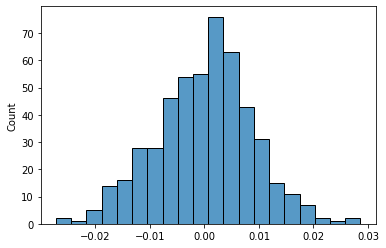

bias:  4.59230837756619e-07
std:  0.008825489007543305


In [42]:
sns.histplot(np.sqrt(n)*(gammas_opt - gamma))
plt.show()
print("bias: ", np.mean(gammas_opt - gamma))
print("std: ", (np.std(np.sqrt(n)*(gammas_opt - gamma))))

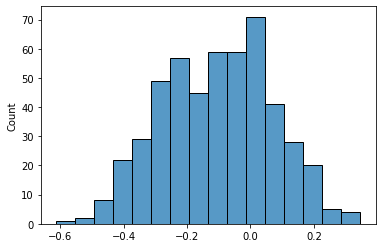

bias:  -0.001151715597330294
std:  0.17506732247881365


In [43]:
sns.histplot(np.sqrt(n)*(gammas_unif - gamma))
plt.show()
print("bias: ", np.mean(gammas_unif - gamma))
print("std: ", (np.std(np.sqrt(n)*(gammas_unif - gamma))))

To see the improvements let's look at the estimation errors under optimal and uniform designs in one plot:

In [54]:
estim_errors = pd.DataFrame({"Optimal": gammas_opt, 
                             "Uniform": gammas_unif})

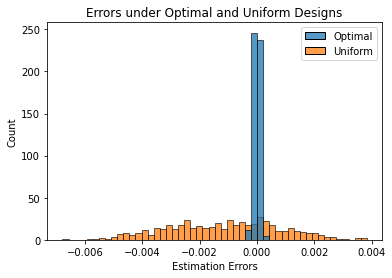

In [61]:
sns.histplot(estim_errors - gamma)
plt.title("Errors under Optimal and Uniform Designs")
plt.xlabel("Estimation Errors")
plt.show()

As you can see in the plot, the estimation errors under the optimal design are much more concentrated around zero than when using a uniform design. 

# More simulations

In [114]:
from scipy.linalg import toeplitz
from sklearn.linear_model import Lasso, LassoCV
from random import sample
import cvxpy as cp
from scipy.stats import norm

In [74]:

N = 1000
p = 500
n = 200
ss = [5, 10]
mc_samples = 500



kappas = [0.1, 0.9]
# Sigma = toeplitz(kappa ** np.arange(p)).T
# u_unif = np.linalg.solve(Sigma, c)


lambda_theory = np.sqrt(np.log(p) / n)

In [99]:
np.random.seed(1)

beta_hat = np.zeros(p)
gamma_hats_unif = np.zeros([2, len(kappas), len(ss), mc_samples])
vars_unif = np.zeros([2, len(kappas), len(ss), mc_samples])
gammas = np.zeros([2, len(kappas), len(ss)])
    
for k in range(len(kappas)):
    Sigma = toeplitz(kappas[k] ** np.arange(p)).T
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=N)
    for l in [0,1]:
        for j in range(len(ss)):
            beta = np.concatenate((np.arange(ss[j],0, -1), np.zeros(p - ss[j])), axis = 0) / ss[j]
            c = np.zeros(p)
            c[ss[j] + l - 1] = 1

            u_unif = np.linalg.solve(X.T @ X / N, c)

            signal = X @ beta
            gammas[l, k,j] = c.T @ beta
            
            for i in range(mc_samples):
                indices = np.random.choice(range(N), size=n)
                y = signal[indices] + np.random.normal(size=n)
                gamma_hats_unif[l, k, j, i], beta_hat = deb_lasso(X[indices,:], y, c, u_unif, lambda_theory, beta_hat.copy())
                vars_unif[l, k, j, i] = u_unif.T @ X[indices,:].T @ X[indices,:] @ u_unif / (n**2)
                print_progress(mc_samples, i)

99 % done


In [100]:
np.mean(gamma_hats_unif, axis = 3) - gammas

array([[[-0.00741991, -0.00499849],
        [ 0.00338051, -0.01087915]],

       [[-0.00609174, -0.01040796],
        [-0.00483919, -0.01336414]]])

In [101]:
np.std(gamma_hats_unif, axis = 3)

array([[[0.10092128, 0.10586833],
        [0.28455224, 0.31579955]],

       [[0.10239152, 0.10247408],
        [0.29687626, 0.3008129 ]]])

In [103]:
np.mean(np.sqrt(vars_unif), axis = 3)

array([[[0.09747906, 0.10026493],
        [0.30239911, 0.30653389]],

       [[0.10534118, 0.09685147],
        [0.30538942, 0.30126461]]])

In [95]:
np.random.seed(1)

beta_hat = np.zeros(p)
gamma_hats_opt = np.zeros([2, len(kappas), len(ss), mc_samples])
vars_opt = np.zeros([2, len(kappas), len(ss), mc_samples])
gammas = np.zeros([2, len(kappas), len(ss)])
    
for k in range(len(kappas)):
    Sigma_init = toeplitz(kappas[k] ** np.arange(p)).T
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma_init, size=N)
    for l in [0,1]:
        for j in range(len(ss)):
            beta = np.concatenate((np.arange(ss[j],0, -1), np.zeros(p - ss[j])), axis = 0) / ss[j]
            c = np.zeros(p)
            c[ss[j] + l - 1] = 1

            signal = X @ beta
            gammas[l, k,j] = c.T @ beta
            w_opt = c_optimize(X, c)
            u_opt = np.linalg.solve(X.T @ np.diag(w_opt) @ X, c)

            for i in range(mc_samples):
                indices = np.random.choice(range(N), size=n, p = w_opt)
                y = signal[indices] + np.random.normal(size=n)
                gamma_hats_opt[l, k, j, i], beta_hat = deb_lasso(X[indices,:], y, c, u_opt, lambda_theory, beta_hat.copy())
                vars_opt[l, k, j, i] = u_opt.T @ X[indices,:].T @ X[indices,:] @ u_opt / (n**2)
                print_progress(mc_samples, i)

99 % done


In [104]:
np.mean(gamma_hats, axis = 3) - gammas

array([[[-0.0070414 , -0.01145838],
        [-0.00760301,  0.0053687 ]],

       [[-0.00617892, -0.00402471],
        [-0.00947508,  0.01922104]]])

In [105]:
1 - np.std(gamma_hats, axis = 3) / np.std(gamma_hats_unif, axis = 3)

array([[[0.2940931 , 0.29714243],
        [0.26387482, 0.36025669]],

       [[0.32671739, 0.30394531],
        [0.32258355, 0.3138248 ]]])

In [106]:
np.std(gamma_hats, axis = 3)

array([[[0.07124103, 0.07441036],
        [0.20946607, 0.20203065]],

       [[0.06893843, 0.07132756],
        [0.20110886, 0.20641035]]])

In [109]:
np.mean(np.sqrt(vars_opt), axis = 3)

array([[[0.06499012, 0.06712503],
        [0.20856639, 0.20622425]],

       [[0.06990412, 0.065541  ],
        [0.19831938, 0.20068078]]])

In [116]:
normal_cdf = norm().cdf

z_025 = normal_cdf(0.25)

In [117]:
z_025

0.5987063256829237

In [125]:
gamma_hats_unif + np.sqrt(vars_unif) * norm().interval(0.95)[0]

array([[[[ 0.11255274,  0.19189783, -0.12539677, ...,  0.31403056,
          -0.1168059 ,  0.06822752],
         [-0.09189414, -0.21573104, -0.05496396, ..., -0.12841808,
          -0.15969322,  0.066477  ]],

        [[-0.78671038, -0.56967056,  0.12401903, ..., -0.49258596,
          -0.14489966, -0.4287725 ],
         [-0.25041649, -0.70978226, -0.3106735 , ..., -0.61244229,
          -0.87701756, -0.51702236]]],


       [[[-0.27864002, -0.40923738, -0.26565186, ..., -0.12802517,
          -0.183045  , -0.24856227],
         [-0.40926533, -0.39168361, -0.10502705, ..., -0.20977873,
          -0.27682197, -0.19540451]],

        [[-0.60284184, -0.77659536, -0.24842755, ..., -0.48971923,
          -0.64960679, -0.24581322],
         [-0.26601976, -0.13329396, -0.1437852 , ..., -0.66918909,
          -0.31084828, -0.77755537]]]])

In [146]:
np.sum((gamma_hats_opt +
        np.sqrt(vars_opt) *
        norm().interval(0.95)[0]) > 0, axis = 3) / mc_samples +\
            np.sum((gamma_hats_opt[:,:,:,:] +
                np.sqrt(vars_opt)[:,:,:,:] *
                norm().interval(0.95)[1]) < 0, axis = 3) / mc_samples

array([[[0.806, 0.29 ],
        [0.156, 0.078]],

       [[0.048, 0.064],
        [0.042, 0.056]]])

In [147]:
np.sum((gamma_hats_unif +
        np.sqrt(vars_unif) *
        norm().interval(0.95)[0]) > 0, axis = 3) / mc_samples +\
            np.sum((gamma_hats_unif[:,:,:,:] +
                np.sqrt(vars_unif)[:,:,:,:] *
                norm().interval(0.95)[1]) < 0, axis = 3) / mc_samples

array([[[0.496, 0.152],
        [0.096, 0.064]],

       [[0.054, 0.058],
        [0.048, 0.046]]])

In [151]:
np.sum((gamma_hats_opt +
        np.sqrt(vars_opt) *
        norm().interval(0.95)[0]) < gammas, axis = 3) / mc_samples 

ValueError: operands could not be broadcast together with shapes (2,2,2,500) (2,2,2) 

In [224]:
gammas_array = np.array([gammas.T] * mc_samples).T

In [232]:
np.sum(((gamma_hats_opt +
        np.sqrt(vars_opt) *
        norm().interval(0.95)[0]) <= gammas_array) *\
       ((gamma_hats_opt +
        np.sqrt(vars_opt) *
        norm().interval(0.95)[1]) >= gammas_array),axis = 3) / mc_samples 

array([[[0.928, 0.926],
        [0.938, 0.944]],

       [[0.952, 0.936],
        [0.958, 0.944]]])

In [233]:
np.sum(((gamma_hats_unif +
        np.sqrt(vars_unif) *
        norm().interval(0.95)[0]) <= gammas_array) *\
       ((gamma_hats_unif +
        np.sqrt(vars_unif) *
        norm().interval(0.95)[1]) >= gammas_array),axis = 3) / mc_samples 

array([[[0.952, 0.936],
        [0.97 , 0.938]],

       [[0.946, 0.942],
        [0.952, 0.954]]])

In [238]:
np.sqrt(n) * np.std(gamma_hats_opt, axis = 3)

array([[[1.00750026, 1.05232134],
        [2.96229758, 2.85714482]],

       [[0.97493665, 1.00872406],
        [2.84410876, 2.91908322]]])

In [237]:
np.sqrt(n) * np.std(gamma_hats_unif, axis = 3)

array([[[1.4272424 , 1.49720426],
        [4.02417638, 4.46608003]],

       [[1.4480348 , 1.4492023 ],
        [4.19846428, 4.25413685]]])